In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
import math
import descartes
from shapely.geometry import Point,Polygon

You need Middle_Layer_Super_Output_Areas_December_2011_Boundaries_EW_BGC and Local_Authority_Districts_December_2019_Boundaries_UK_BFC as well as SAPE21DT4-mid-2018-msoa-syoa-estimates-unformatted.xlsx and ukmidyearestimates20182019ladcodes.xls and finally wu02ew_msoa and a version CurrentState that you produce in MakingCurrentStateOutOfInferenceData.ipynb for which you need to run the extremely long inference code on the English death data with literature parameters (or equivalent).
The data needed to run this notebook can be found [here](https://universityofcambridgecloud-my.sharepoint.com/:u:/g/personal/pbr28_cam_ac_uk/Ec-3aa6AR_xNvPbr7WqL7UsBhTxG-4TsVfzrrG7i_32GIw?e=l8ooyM). (Download the full zip archive, otherwise OneDrive complains.)

In [2]:

# Available options for generating the commuterverse network are listed here:

# Without cutting out small commute directions, the commuter network is very dense.
# We allow two types of cutoffs (that can be deactivated by setting them to 0):
# Ignore connection if fewer than this many people commute between two nodes (all ages)
all_age_cutoff = 10
# Ignore connection if fewer than this many people of a certain age group commute between two nodes
individual_age_cutoff = 3

# When the cutoffs are > 0, the number of nodes in the commuterverse gets reduced, which also
# reduces the overall number of people that commute to work. If this value is set to true,
# the the remaining nodes in the commuterverse get rescaled such that the overall number of
# people commuting remains the same.
rescale_work_population = True 

# Edit this function to add infected (or recovered) people to the network
def add_infected(table):
    # Example:
    #     table.loc[0, '16-24'] -= 5  # Susceptible 
    #     table.loc[0, '16-24_I'] += 5  # Infected
    #     table.loc[0, '16-24_R'] += 0  # Recovered
    # Adds 5 infected people in the City of London. First index is node id, second index is age group.
    pass  # No infected added


# Define average commute speed. The commute time is then computed using the distance between different MSOAs.
avg_commuting_speed = 20.0  # in km/h

# TODO: add choices for computing the commuting window here. At the moment, the logic for this is in the function
#       that saves the files, at the end of this notebook.

# TODO2: At the moment, people that work in the same node as they live are not added to the commuterverse. I am happy
#        to implement this when needed, however, we would need to decide on a value for the commute time then.

First we make the map of Britain, load scottish LADS and EW MSOAs and combine them. Check ONS coding if you do not understand

In [35]:
ScotLads={'Na h-Eileanan Siar',"Clackmannanshire",'Dumfries and Galloway',"East Ayrshire","East Lothian","East Renfrewshire","Eilean Siar","Falkirk", "Fife","Highland","Inverclyde", "Midlothian","Moray","North Ayrshire","Orkney Islands","Perth and Kinross","Scottish Borders",	"Shetland Islands",	"South Ayrshire", "South Lanarkshire", "Stirling", "Aberdeen City",	"Aberdeenshire", "Argyll and Bute",	"City of Edinburgh", "Renfrewshire", "West Dunbartonshire",	"West Lothian","Angus",	"Dundee City",	"North Lanarkshire",	"East Dunbartonshire",	"Glasgow City"}
Lads=gpd.read_file("shape/Local_Authority_Districts_December_2019_Boundaries_UK_BFC.shp")
SLads=Lads[Lads.lad19nm.isin(ScotLads)]
SLads=SLads.drop(columns=['objectid',"lad19nm",'lad19nmw','bng_e','bng_n','long','lat','st_lengths'])
SLads=SLads.rename(columns={'lad19cd':'AreaCode'})
SLads=SLads.to_crs(epsg=3395)
# SLads

In [36]:
geometry_msoa = gpd.read_file("shape/Middle_Layer_Super_Output_Areas_December_2011_Boundaries_EW_BGC.shp")
geometry_msoa=geometry_msoa.drop(columns=['objectid',"msoa11nm",'msoa11nmw','st_lengths'])
geometry_msoa=geometry_msoa.rename(columns={'msoa11cd':'AreaCode'})
geometry_msoa=geometry_msoa.to_crs(epsg=3395)
geometry_msoa.head()

,AreaCode,st_areasha,geometry
0,E02000001,2.905399e+06,"MULTIPOLYGON (((-10774.144 6680905.516, -10739..."
1,E02000002,2.165634e+06,"POLYGON ((16484.756 6694037.987, 16482.035 669..."
2,E02000003,2.143565e+06,"POLYGON ((16767.621 6691585.838, 16517.775 669..."
3,E02000004,2.490215e+06,"POLYGON ((20603.001 6688323.301, 20482.619 668..."
4,E02000005,1.186180e+06,"POLYGON ((16684.345 6688907.596, 16781.998 668..."


As a check we plot all of the places we have loaded and get a represntative point of each location to estimate travel times

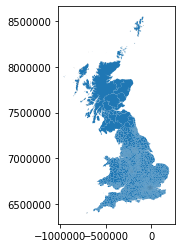

In [37]:
GB = gpd.GeoDataFrame(pd.concat([geometry_msoa,SLads], ignore_index=True), crs=geometry_msoa.crs)
GB.to_file(driver = 'ESRI Shapefile', filename= "GB.shp")
GB["Center"]=GB.representative_point() 
GB.plot()

In [38]:
Lads=Lads.rename(columns={"lad19cd":'AreaCode'})

Next we will find the link between the LADs in which the current state is and the MSOAs which is what we will simulating in England and Wales.

In [39]:
Lads=Lads.rename(columns={'lad19cd':'AreaCode'})
msoa_to_lad = pd.read_csv('data/PCD_OA_LSOA_MSOA_LAD_FEB20_UK_LU.csv', encoding="latin_1", low_memory=False)
msoa_to_lad=msoa_to_lad.drop(columns=['pcd7','pcd8','pcds','dointr','doterm','usertype','oa11cd','lsoa11cd','lsoa11nm','msoa11nm','ladnm','ladnmw'])
msoa_to_lad=msoa_to_lad.rename(columns={'ladcd':'AreaCode'})
listUno=msoa_to_lad[msoa_to_lad['AreaCode'].isin(GB.AreaCode)]
listUno=listUno.drop_duplicates(subset=['AreaCode'], keep='first')
listUno=listUno[listUno['AreaCode'].isin(GB.AreaCode)]
listUno=listUno.drop(columns=['msoa11cd'])
listUno['ladcd']=listUno['AreaCode']
listDuo=msoa_to_lad[msoa_to_lad['msoa11cd'].isin(GB.AreaCode)==True]
listDuo=listDuo.rename(columns={'AreaCode':'ladcd','msoa11cd':'AreaCode'})
listDuo=listDuo.drop_duplicates(subset=['AreaCode'], keep='first')
msoa_to_lad=pd.concat([listUno, listDuo], ignore_index=True)

In [40]:
listDuo

,AreaCode,ladcd
38772,E02004937,E07000240
38773,E02004936,E07000240
38777,E02004940,E07000240
38784,E02004939,E07000240
38785,E02004935,E07000240
...,...,...
2629497,E02002698,E06000011
2633522,E02005758,E07000164
2636435,E02005757,E07000164
2637542,E02005813,E07000169


In [41]:
LadsMerged=Lads
LadsMerged=LadsMerged.rename(columns={'AreaCode':'ladcd'})
LadsMerged=LadsMerged[LadsMerged['ladcd'].isin(msoa_to_lad.ladcd)]
LadsMerged=LadsMerged.drop(columns=['bng_e','bng_n','long','lat','st_lengths', 'st_areasha', 'objectid', 'lad19nmw'])
LadsMerged=LadsMerged.reset_index(drop=True)
LadsMerged=LadsMerged.reset_index(drop=False)
LadsMerged.to_file("LadsGB.shp")

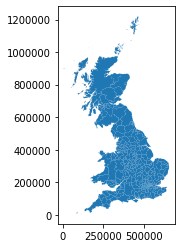

In [42]:
LadsMerged.plot()

In [43]:
ListOfLads=['E07000004', 'E07000005', 'E07000006', 'E07000007'] 

In [44]:
LadsMerged[LadsMerged['ladcd'].isin(ListOfLads)]

,index,ladcd,lad19nm,geometry
56,56,E07000004,Aylesbury Vale,"POLYGON ((472045.402 242897.101, 472047.999 24..."
57,57,E07000005,Chiltern,"POLYGON ((491748.698 208468.096, 491775.198 20..."
58,58,E07000006,South Bucks,"POLYGON ((494609.100 193735.803, 494624.699 19..."
59,59,E07000007,Wycombe,"POLYGON ((482443.298 209734.304, 482467.398 20..."


In [47]:
LadsMerged=Lads
LadsMerged=LadsMerged.rename(columns={'AreaCode':'ladcd'})
LadsMerged=LadsMerged[LadsMerged['ladcd'].isin(msoa_to_lad.ladcd)]
LadsMerged=LadsMerged.drop(columns=['lad19nmw','bng_e','bng_n','long','lat','st_lengths', 'geometry', 'st_areasha', 'objectid'])
LadsMerged=LadsMerged.reset_index(drop=True)
LadsMerged=LadsMerged.reset_index(drop=False)
LadsMerged=LadsMerged.rename(columns={'index':'objectid','msoa11cd':'AreaCode'})
LadsSaved=LadsMerged
LadsMerged
LadsMerged=msoa_to_lad.merge(LadsMerged, on='ladcd')
LadsMerged

,AreaCode,ladcd,objectid,lad19nm
0,S12000033,S12000033,335,Aberdeen City
1,S12000034,S12000034,336,Aberdeenshire
2,S12000041,S12000041,342,Angus
3,S12000020,S12000020,327,Moray
4,S12000017,S12000017,324,Highland
...,...,...,...,...
7228,E02002779,E06000014,13,York
7229,E02002773,E06000014,13,York
7230,E02002775,E06000014,13,York
7231,E02002777,E06000014,13,York


In [55]:
MidArray=LadsSaved['objectid'].values
for i in range(0, len(MidArray)):
    if((MidArray[i] == 57) or(MidArray[i] == 58) or (MidArray[i] == 59)):
        MidArray[i]=56
    if(MidArray[i] >59 ):
         MidArray[i]=MidArray[i]-3
LadsSaved['objectid']=pd.Series(MidArray)
LadsSaved=LadsSaved.drop(columns=['lad19nm'])
LadsSaved.to_csv("LadsUkSaved.csv")

In [52]:
MidArray=LadsMerged['objectid'].values
for i in range(0, len(MidArray)):
    if((MidArray[i] == 57) or(MidArray[i] == 58) or (MidArray[i] == 59)):
        MidArray[i]=56
    if(MidArray[i] >59 ):
         MidArray[i]=MidArray[i]-3
LadsMerged['objectid']=pd.Series(MidArray)

Now we load the resident data from ONS and put it into the usual commuting age groups

We load the commuting groups and set a cutoff of 10 to not simulate too few people

In [28]:
cutoff=10
seriesEW=geometry_msoa['AreaCode']
#Load Scottish commute data
ScotCom=pd.read_csv("ScottishCommute.csv")
age_commute_table = pd.read_csv("data/wu02ew_msoa.csv")
#Trim down to data that is in the map
age_commute_table=age_commute_table[age_commute_table['Area of residence'].isin(seriesEW)]
age_commute_table=age_commute_table[age_commute_table['Area of workplace'].isin(seriesEW)]
ScotCom=ScotCom.drop(columns=["index"])
age_commute_table=pd.concat([age_commute_table,ScotCom], ignore_index=True)
age_commute_tableTot=age_commute_table[age_commute_table['All categories: Age 16 and over']>cutoff].reset_index(drop=True)
age_commute_table=age_commute_table[age_commute_table['Area of residence']!=age_commute_table['Area of workplace']]
age_commute_table=age_commute_table[age_commute_table['All categories: Age 16 and over']>cutoff].reset_index(drop=True)



In [70]:
age_commute_tableSummed=age_commute_tableTot[age_commute_tableTot['Area of residence']==age_commute_tableTot['Area of workplace']]
age_commute_tableSummed=age_commute_tableSummed.reset_index(drop=True)
age_commute_tableSummed=age_commute_tableSummed.rename(columns={"Area of residence":"AreaCode"})
# If you chose to rescale this is where you rescale to 2018 population
work_age_groups = ['16-24', '25-34', '35-49', '50-64', '65-74', '75+']
if rescale_work_population:
    for i in range(0,len(age_commute_tableSummed)):
        j=resident_data_2011.loc[resident_data_2011['AreaCode'] == age_commute_tableSummed['AreaCode'][i]]
        k=resident_data_2018.loc[resident_data_2018['AreaCode']  == age_commute_tableSummed['AreaCode'][i]]
        for (l, age_group) in enumerate(work_age_groups[0:]):
            age_commute_tableSummed[age_group][i]=age_commute_tableSummed[age_group][i]*k[age_group].values/j[age_group].values
# age_commute_tableSummed=GB.merge(age_commute_tableSummed, on='AreaCode')
# age_commute_tableSummed=age_commute_tableSummed.merge(resident_data_2018, on='AreaCode')


/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Next we compute the time that each commuting person takes to get to there destination and transform from ONS coding to the code of the algorithm, this might take a while

In [30]:
LadsMerged2=LadsMerged
LadsMerged2=LadsMerged2.drop(columns=['lad19nm'])
LadsMerged2=LadsMerged2.rename(columns={"AreaCode":"Area of residence"})
age_commute_table=age_commute_table.merge(LadsMerged2, on="Area of residence")
LadsMerged2=LadsMerged2.rename(columns={"Area of residence":"Area of workplace"})
age_commute_table=age_commute_table.merge(LadsMerged2, on="Area of workplace")
age_commute_table

,Area of residence,Area of workplace,All categories: Age 16 and over,16-24,25-34,35-49,50-64,65-74,75+,ladcd_x,objectid_x,ladcd_y,objectid_y
0,E02000001,E02000186,31.0,4.0,10.0,13.0,4.0,0.0,0.0,E09000001,281,E09000007,287
1,E02000003,E02000186,12.0,1.0,1.0,4.0,6.0,0.0,0.0,E09000002,282,E09000007,287
2,E02000008,E02000186,11.0,2.0,1.0,5.0,3.0,0.0,0.0,E09000002,282,E09000007,287
3,E02000013,E02000186,14.0,2.0,4.0,6.0,2.0,0.0,0.0,E09000002,282,E09000007,287
4,E02000016,E02000186,11.0,1.0,4.0,6.0,0.0,0.0,0.0,E09000002,282,E09000007,287
...,...,...,...,...,...,...,...,...,...,...,...,...,...
311783,S12000017,S12000013,46.0,5.0,10.0,15.0,12.0,2.0,2.0,S12000017,321,S12000013,319
311784,S12000028,S12000013,11.0,0.0,1.0,6.0,4.0,0.0,0.0,S12000028,329,S12000013,319
311785,S12000035,S12000013,23.0,1.0,2.0,7.0,11.0,2.0,0.0,S12000035,334,S12000013,319
311786,S12000017,S12000023,57.0,5.0,9.0,22.0,19.0,2.0,0.0,S12000017,321,S12000023,326


In [32]:
speed=20000
series=GB['AreaCode']
work_age_groups = ['16-24', '25-34', '35-49', '50-64', '65-74', '75+']
Tdistance=np.zeros(len(age_commute_table))
for i in range(0,len(age_commute_table)):
    # If you chose to rescale this is where you rescale to 2018 population
    j=series[series==age_commute_table['Area of residence'][i]].index[0]
    k=series[series==age_commute_table['Area of workplace'][i]].index[0]
    age_commute_table['Area of residence'][i]=j
    age_commute_table['Area of workplace'][i]=k
    x1=GB['Center'][j].x
    y1=GB['Center'][j].y
    x2=GB['Center'][k].x
    y2=GB['Center'][k].y
    distance=(x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)
    Tdistance[i]=np.sqrt(distance)/speed
    if(Tdistance[i]>3):
        Tdistance[i]=3
age_commute_table['TemporalDistance']=Tdistance
age_commute_table.insert(2, '0-15', np.zeros(len(age_commute_table.index), dtype=int))

/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [33]:
# 1. Write down the commute network:

# Get into the format neede for the algorithm: Rows of the form
#     Age group nr, residence index, residence index, work index, number of people commuting (scaled to 2019), 
#     commute start 1, commute start 2, commute end 1, commute end 2, allow S, allow I, allow R
# written in a CSV file.
# This may take a while!
filename = 'commuter_networks.csv'
allow_S = 1
allow_E = 1
allow_A = 1
allow_Ia1 = 1
allow_Ia2 = 1
allow_Ia3 = 1
allow_Is1 = 0
allow_Is2 = 0
allow_Is3 = 0
allow_R = 1
work_age_groups = ['0-15', '16-24', '25-34', '35-49', '50-64', '65-74', '75+']
with open(filename,  'w') as f:
    f.write("Home,From,To,Age,#to_move,%to_move,t1,t2,ct1,ct2,allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)\n")
    for j in age_commute_table.index:
        row = age_commute_table.loc[j]
        if(row['objectid_x']!=row['objectid_y']):
            for (i, age_group) in enumerate(work_age_groups[1:]):
                count = row[age_group].astype(int)

                # Everyone is in office between 9:00 and 10:00 and leaves between 17:00 and 18:00:
                buffer = min(row.TemporalDistance, 1.0)

                morning_start_1 = 9 - row.TemporalDistance
                morning_start_2 = 9 - row.TemporalDistance + buffer
                morning_end_1 = 9
                morning_end_2 = 9 + buffer

                evening_start_1 = 17
                evening_start_2 = 17 + buffer
                evening_end_1 = 17 + row.TemporalDistance
                evening_end_2 = 17 + row.TemporalDistance + buffer

                if count > individual_age_cutoff:
                    # home -> work
                    f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}  \n".format(
                            int(row['objectid_x']), int(row['objectid_y']),  int(row['objectid_y']),  i+3,
                            count,-1, morning_start_1, morning_start_2, morning_end_1, morning_end_2,
                            allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)
                        )
                    # work -> home
                    f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {} , {} \n".format(
                            int(row['objectid_x']), int(row['objectid_y']),  int(row['objectid_y']),  i+3, 
                            -1, 1, evening_start_1, evening_start_2, evening_end_1, evening_end_2,
                            allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)
                        )